In [108]:
%matplotlib inline
import numpy as np, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

In [109]:
x,sr = librosa.load('../data/grandpiano.wav',duration=10)

In [110]:
fmin = 27.5 # min frequency in piano
hop_length = 512
C = librosa.cqt(x, sr=sr, fmin=fmin, n_bins=72, hop_length=hop_length)

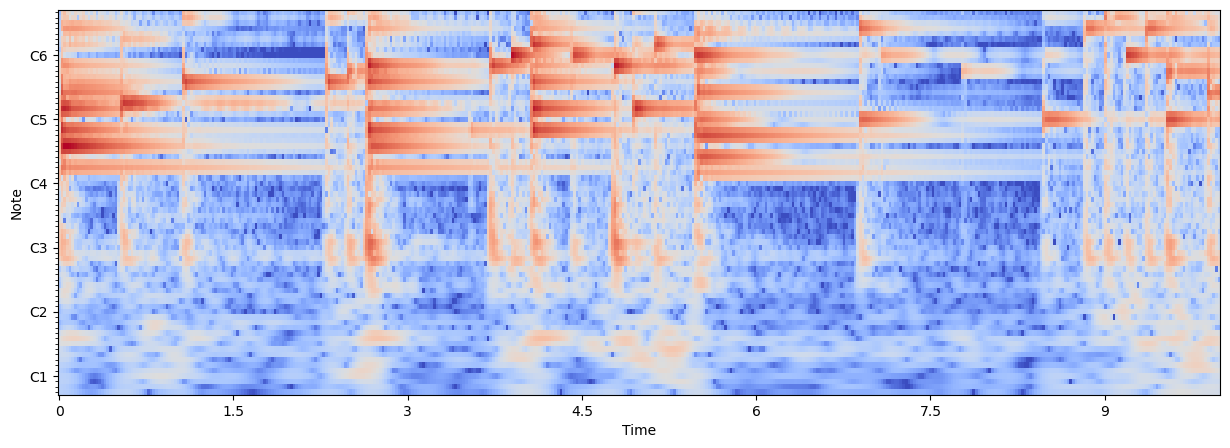

In [111]:
logC = librosa.amplitude_to_db(numpy.abs(C))
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')

In [112]:
# CQT Threshold to get rid of noise, harmonics, etc
def cqt_thresholded(cqt,thres=-61):
    new_cqt=np.copy(cqt)
    new_cqt[new_cqt<thres]=-120
    return new_cqt

Cdb = cqt_thresholded(logC)

In [113]:
# Onset Envelope, onset boundaries, and onset times from Cqt
onset_env = librosa.onset.onset_strength(S=Cdb, sr=sr, aggregate=np.mean, hop_length=hop_length)
onset_frames = librosa.onset.onset_detect(onset_env,
                                           sr=sr, units='frames', 
                                           hop_length=hop_length, 
                                           backtrack=False,
                                           pre_max=6,
                                           post_max=6)
onset_boundaries = np.concatenate([[0], onset_frames, [Cdb.shape[1]]])
onset_times = librosa.frames_to_time(onset_boundaries, sr=sr, hop_length=hop_length)

/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_16354/4282869224.py:3: FutureWarning: Pass y=[0.00000000e+00 0.00000000e+00 0.00000000e+00 9.80499744e+00
 1.39799809e+00 1.46389091e+00 9.03295934e-01 7.14135110e-01
 5.28057098e-01 2.10258031e+00 4.23422337e+00 3.97869325e+00
 2.15234256e+00 3.21513271e+00 1.33704555e+00 4.46864271e+00
 1.24839020e+00 6.36879921e+00 4.04774809e+00 2.94465899e+00
 1.95065665e+00 4.02347517e+00 1.20074475e+00 5.63040614e-01
 1.58867559e+01 8.79980850e+00 1.44583774e+00 1.92625725e+00
 1.52063644e+00 1.90913522e+00 1.93656981e+00 2.59906602e+00
 1.75676537e+00 4.49535704e+00 2.07523847e+00 9.74938691e-01
 2.41465116e+00 4.75534856e-01 6.11078405e+00 4.13659859e+00
 1.46280503e+00 2.18541551e+00 3.20587206e+00 2.32391715e+00
 4.01335049e+00 4.15946770e+00 4.09358740e+00 7.70060825e+00
 1.33159218e+01 2.29557967e+00 4.28256893e+00 2.78106713e+00
 3.44622517e+00 1.72784090e+00 2.31838822e+00 3.13921094e+00
 2.97455096e+00 8.60159969e+00 2.30379796e

In [114]:
# Estimate Tempo
tempo, beats=librosa.beat.beat_track(y=None, sr=sr, onset_envelope=onset_env, hop_length=hop_length,
               start_bpm=120.0, tightness=100, trim=True, bpm=None,
               units='frames')
tempo=int(2*round(tempo/2))

In [115]:
#estimnate pitch with segments
def estimate_pitch(segment,sr,fmin=fmin,fmax=2000.0):
    #compute autocorrelation of input segment
    R = librosa.autocorrelate(segment)

    #define lower and upper limits for the autocorrelation argmax
    i_min = sr/fmax
    i_max = sr/fmin
    R[:int(i_min)] = 0
    R[:int(i_max)] = 0

    #find the location of the maximum autocorrelation
    i = R.argmax()
    f0 = float(sr)/i
    return f0

In [116]:
#generate sine wave
def generate_sine(f0,sr,n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [117]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

In [118]:
y = np.concatenate([
    estimate_pitch_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_16354/2929405846.py:14: RuntimeWarning: divide by zero encountered in divide
  f0 = float(sr)/i
/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_16354/376530307.py:4: RuntimeWarning: invalid value encountered in multiply
  return 0.2*np.sin(2*np.pi*f0*n/float(sr))
/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_16354/376530307.py:4: RuntimeWarning: invalid value encountered in sin
  return 0.2*np.sin(2*np.pi*f0*n/float(sr))


In [119]:
ipd.Audio(y, rate=sr)